# Loan prediction

In [1]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import missingno
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
data=pd.read_csv("loan.csv")

In [3]:
data


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


# EDA

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
data.drop("Loan_ID", axis=1, inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


In [7]:
# getting list of object data type column names
object_dt = []
for x in data.dtypes.index:
    if data.dtypes[x] == 'object':
        object_dt.append(x)
print(f"Object Data Type Columns are:\n", object_dt)


# getting the list of float data type column names
number_dt = []
for x in data.dtypes.index:
    if data.dtypes[x] == 'float64' or data.dtypes[x] == 'int64':
        number_dt.append(x)
print(f"\nNumber Data Type Columns are:\n", number_dt)

Object Data Type Columns are:
 ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

Number Data Type Columns are:
 ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


In [9]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


In [11]:
#checking for null values
data.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [13]:
data.nunique()

Gender                 2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           203
Loan_Amount_Term      10
Credit_History         2
Property_Area          3
Loan_Status            2
dtype: int64

In [14]:
#Filling all the missing values and treating them with mean and mode
# filling continous data columns with the mean value of that column
data['LoanAmount'] = data['LoanAmount'].fillna(data['LoanAmount'].mean())
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mean())

# filling categorical data columns with the mode value of that column
data['Credit_History']=data['Credit_History'].fillna(data['Credit_History'].mode()[0])
data['Gender'] = data['Gender'].fillna(data['Gender'].mode()[0])
data['Married'] = data['Married'].fillna(data['Married'].mode()[0])
data['Dependents'] = data['Dependents'].fillna(data['Dependents'].mode()[0])
data['Self_Employed'] = data['Self_Employed'].fillna(data['Self_Employed'].mode()[0])

In [15]:
data.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [16]:
#all the null values are taken care of

# Visualization

In [17]:
print(f"Object Data Type Column Names: \n", object_dt)
print(f"\nNumeric Data Type Column Names: \n", number_dt)

Object Data Type Column Names: 
 ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

Numeric Data Type Column Names: 
 ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


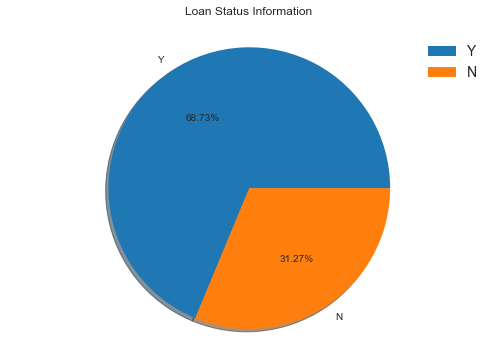

In [18]:
plt.style.use('seaborn-white')
plt.figure(figsize=(7,5))
plt.pie(data['Loan_Status'].value_counts(), labels=data['Loan_Status'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Loan Status Information\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

loan approved status is 68.73% and loan rejected status is 31.27%.

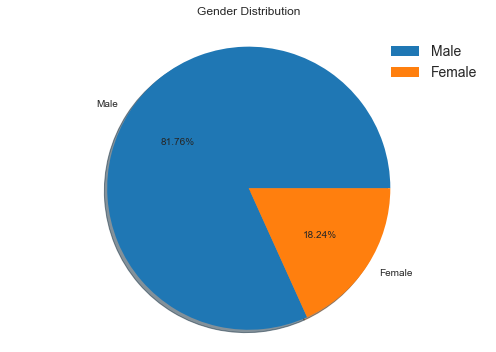

In [19]:
plt.figure(figsize=(7,5))
plt.pie(data['Gender'].value_counts(), labels=data['Gender'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Gender Distribution\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

number of males are 81.76% and number of females are 18.24%

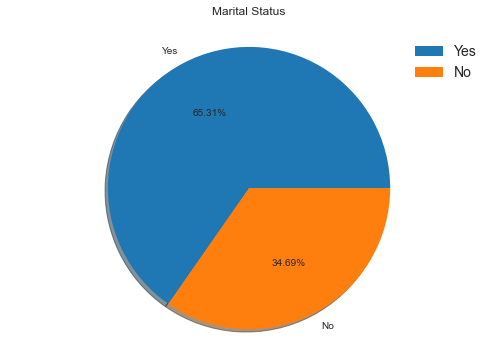

In [20]:
plt.figure(figsize=(7,5))
plt.pie(data['Married'].value_counts(), labels=data['Married'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Marital Status\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

65.31% of rows in Married column are filled with married people and the remaining 34.69% of rows are filled with unmarried people.

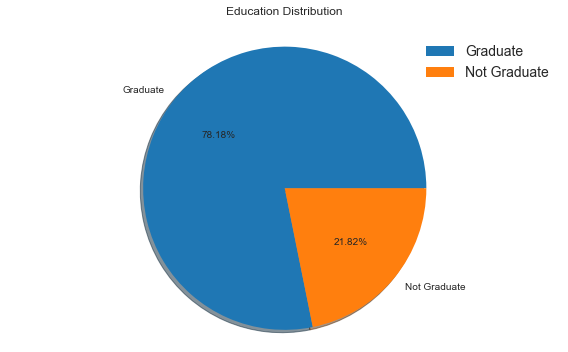

In [21]:
plt.figure(figsize=(8,5))
plt.pie(data['Education'].value_counts(), labels=data['Education'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Education Distribution\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

we can see that 78.18% of rows present in Education column are filled with graduates while the remaining 21.82% rows are filled with under graduate people.

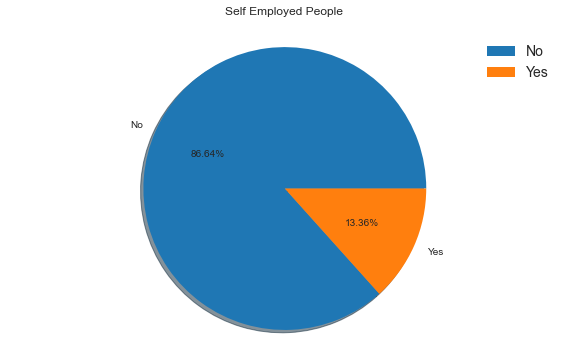

In [22]:
plt.figure(figsize=(8,5))
plt.pie(data['Self_Employed'].value_counts(), labels=data['Self_Employed'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Self Employed People\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()


86.64% people are not self employed and might be working with either private or government sectors while only 13.36% people are self employed owning their businesses.

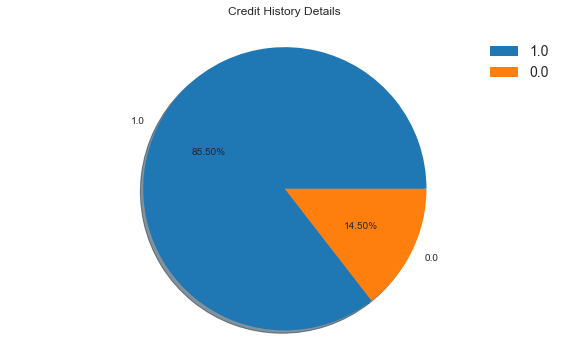

In [23]:
plt.figure(figsize=(8,5))
plt.pie(data['Credit_History'].value_counts(), labels=data['Credit_History'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Credit History Details\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

1.0 represent that credit history is available and 0.0 represent that credit history is not available. For 85.50% of people we have the credit history information available while 14.50% people do not have any credit history.

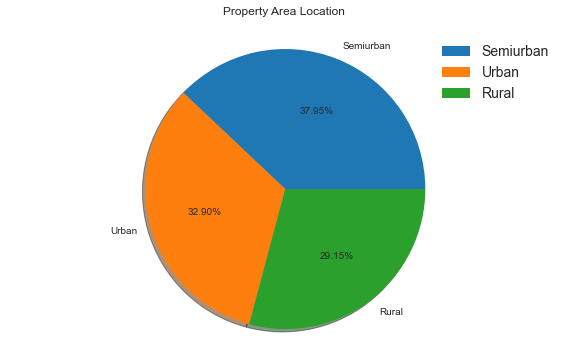

In [24]:
plt.figure(figsize=(8,5))
plt.pie(data['Property_Area'].value_counts(), labels=data['Property_Area'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Property Area Location\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

37.95% rows are covered by semi urban area type, 32.90% rows are covered by urban area type and 29.15% rows are covered by rural area type in our property area column.

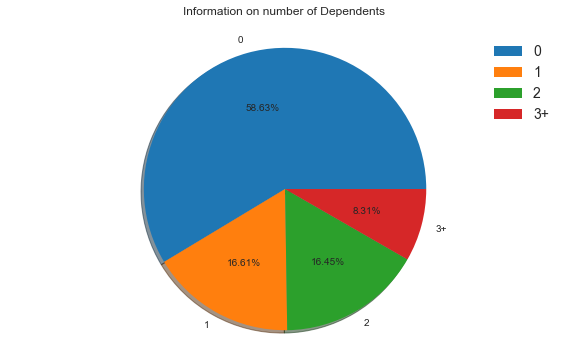

In [25]:
plt.figure(figsize=(8,5))
plt.pie(data['Dependents'].value_counts(), labels=data['Dependents'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Information on number of Dependents\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

 total number of dependants where 56.63% rows are covered with people having 0 dependents, 16.61% rows covered with people having 1 dependent, 16.45% rows covered with people having 2 dependents and 8.31% rows covered with people having 3 or more dependents.

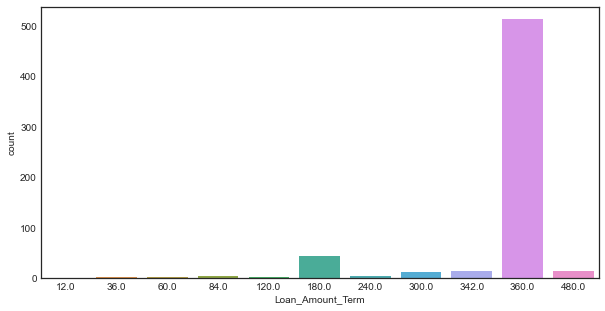

In [28]:
try:
    plt.figure(figsize=(10,5))
    col_name = 'Loan_Amount_Term'
    values = data[col_name].value_counts()
    index = 0
    ax = sns.countplot(data[col_name])
    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='r')
        index += 1
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    pass

that the highest number of rows are covered by the value 360.0 in the "Loan_Amount_Term" column.

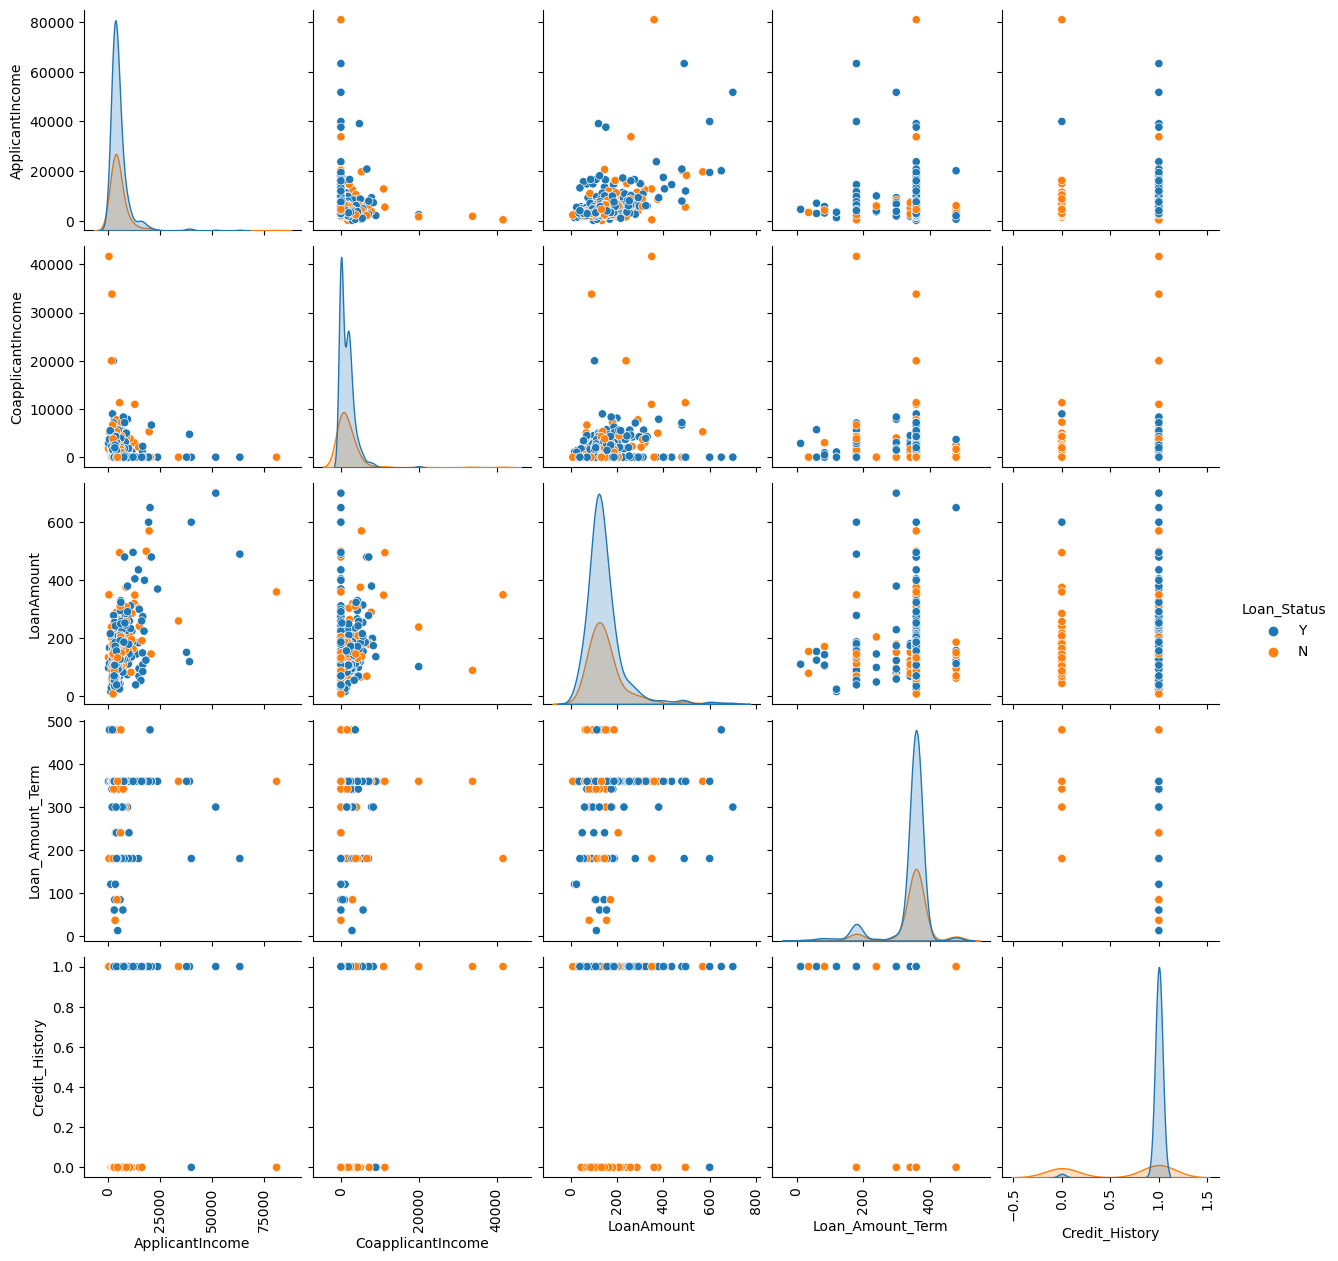

In [29]:
plt.style.use('default')
g = sns.pairplot(data, hue='Loan_Status', diag_kind='kde')
for ax in g.axes.flat:
    ax.tick_params("x", labelrotation=90)
plt.show()

the above pairplot for our continous data columns that shows us how the data points are distributed in each of the numeric datatype columns.

<AxesSubplot:xlabel='LoanAmount', ylabel='Loan_Amount_Term'>

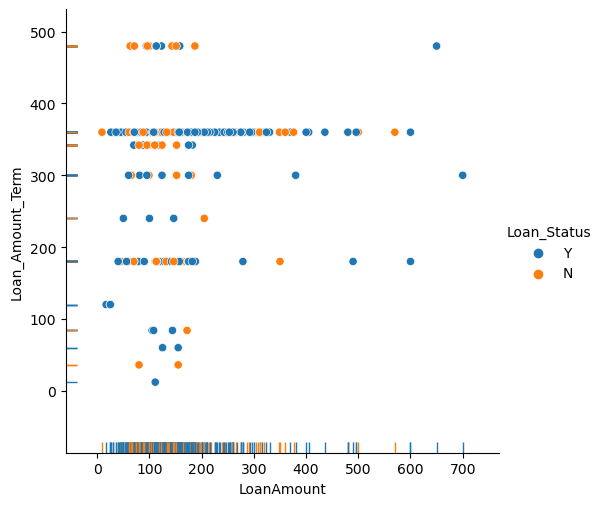

In [30]:
plt.style.use('default')
sns.relplot(data=data, x='LoanAmount', y='Loan_Amount_Term', hue='Loan_Status')
sns.rugplot(data=data, x='LoanAmount', y='Loan_Amount_Term', hue='Loan_Status', legend=False)

most of the data points are accumulated for 180, 300, 340, 360 and 480 terms while loan amount ranging from 50-250 for a term of 480 mostly seems to be getting rejected than approved.

<AxesSubplot:xlabel='LoanAmount', ylabel='Loan_Amount_Term'>

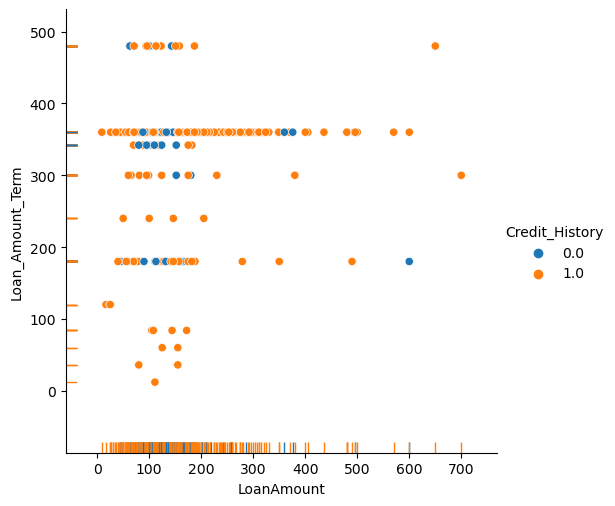

In [31]:
sns.relplot(data=data, x='LoanAmount', y='Loan_Amount_Term', hue='Credit_History')
sns.rugplot(data=data, x='LoanAmount', y='Loan_Amount_Term', hue='Credit_History', legend=False)

In loan amount vs loan amount term datapoints most of the values already have a credit history to showcase.

<AxesSubplot:xlabel='LoanAmount', ylabel='ApplicantIncome'>

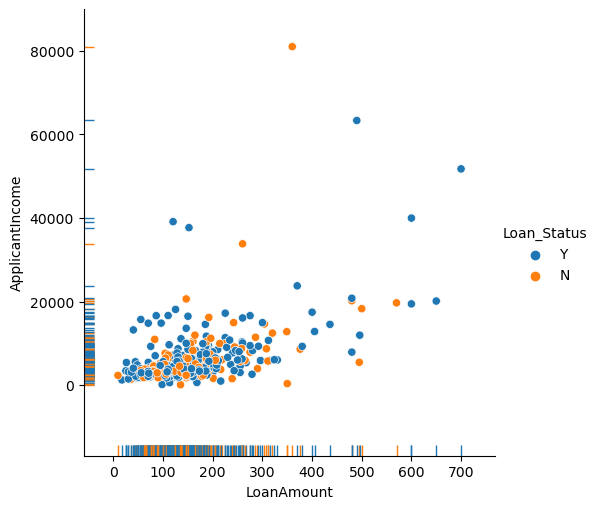

In [32]:
sns.relplot(data=data, x='LoanAmount', y='ApplicantIncome', hue='Loan_Status')
sns.rugplot(data=data, x='LoanAmount', y='ApplicantIncome', hue='Loan_Status', legend=False)

most of the data points are converged near the range 0-20000 data for Applicant Income for mostly loan amount between 0-400

<AxesSubplot:xlabel='LoanAmount', ylabel='ApplicantIncome'>

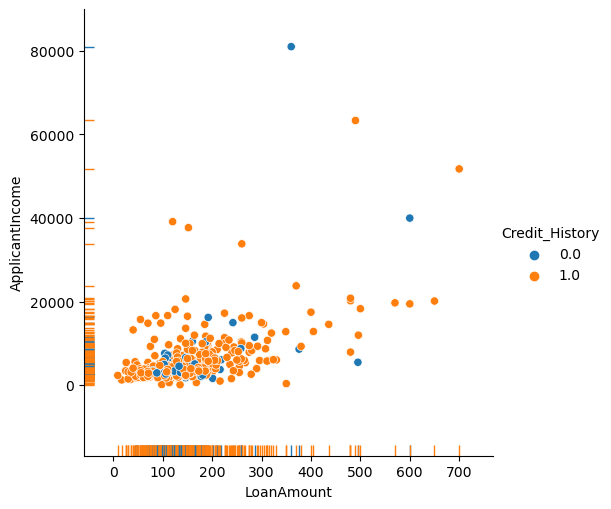

In [34]:
sns.relplot(data=data, x='LoanAmount', y='ApplicantIncome', hue='Credit_History')
sns.rugplot(data=data, x='LoanAmount', y='ApplicantIncome', hue='Credit_History', legend=False)

most of the data points have their credit history available and the values are converged between 0-20000 for applicant income and 0-400 for loan amount data

<AxesSubplot:xlabel='LoanAmount', ylabel='CoapplicantIncome'>

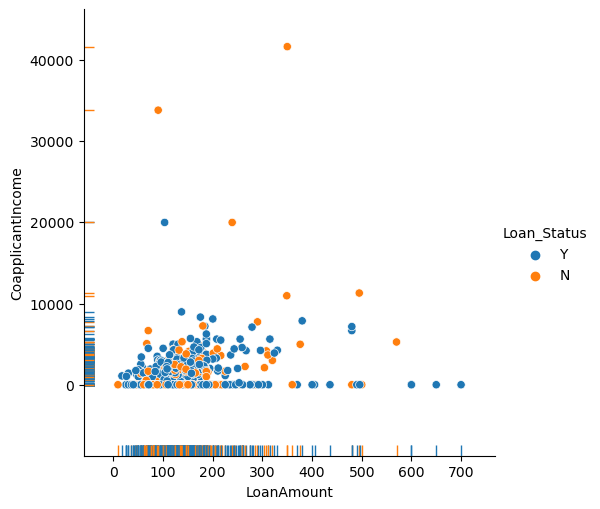

In [35]:
sns.relplot(data=data, x='LoanAmount', y='CoapplicantIncome', hue='Loan_Status')
sns.rugplot(data=data, x='LoanAmount', y='CoapplicantIncome', hue='Loan_Status', legend=False)

The co applicant income vs loan amount data points where in co applicants with higher income are mostly denied loan where most data values are converged between 0-10000 for co applicant income and 0-300 for loan amount data

<AxesSubplot:xlabel='LoanAmount', ylabel='CoapplicantIncome'>

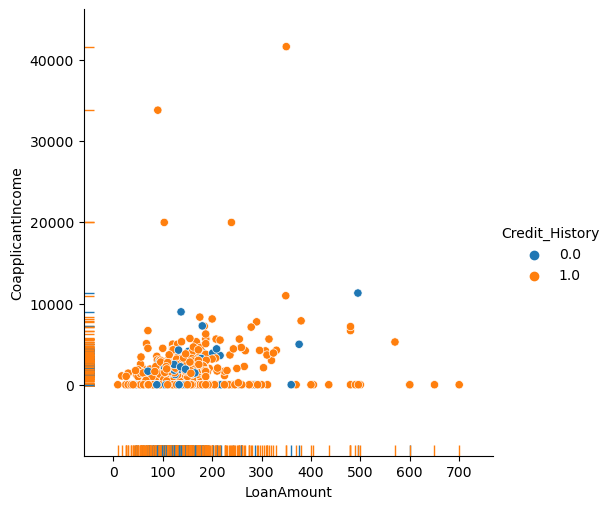

In [36]:
sns.relplot(data=data, x='LoanAmount', y='CoapplicantIncome', hue='Credit_History')
sns.rugplot(data=data, x='LoanAmount', y='CoapplicantIncome', hue='Credit_History', legend=False)

Most of the data points are accumulated between 0-10000 for co applicant income and 0-350 for loan amount data and most of these data points have a credit history available for them

# Encoding

In [37]:
# Label Encoder

le = LabelEncoder()
data["Loan_Status"] = le.fit_transform(data["Loan_Status"])
data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,1
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,1
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,1


 LabelEncoder is used to convert the object data type in our label column "Loan_Status" to a numerical format.

In [38]:
# Ordinal Encoder

oe = OrdinalEncoder()
data['Gender'] = oe.fit_transform(data['Gender'].values.reshape(-1,1))
data['Married'] = oe.fit_transform(data['Married'].values.reshape(-1,1))
data['Dependents'] = oe.fit_transform(data['Dependents'].values.reshape(-1,1))
data['Education'] = oe.fit_transform(data['Education'].values.reshape(-1,1))
data['Self_Employed'] = oe.fit_transform(data['Self_Employed'].values.reshape(-1,1))
data['Property_Area'] = oe.fit_transform(data['Property_Area'].values.reshape(-1,1))
data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1.0,0.0,0.0,0.0,0.0,5849,0.0,146.412162,360.0,1.0,2.0,1
1,1.0,1.0,1.0,0.0,0.0,4583,1508.0,128.000000,360.0,1.0,0.0,0
2,1.0,1.0,0.0,0.0,1.0,3000,0.0,66.000000,360.0,1.0,2.0,1
3,1.0,1.0,0.0,1.0,0.0,2583,2358.0,120.000000,360.0,1.0,2.0,1
4,1.0,0.0,0.0,0.0,0.0,6000,0.0,141.000000,360.0,1.0,2.0,1


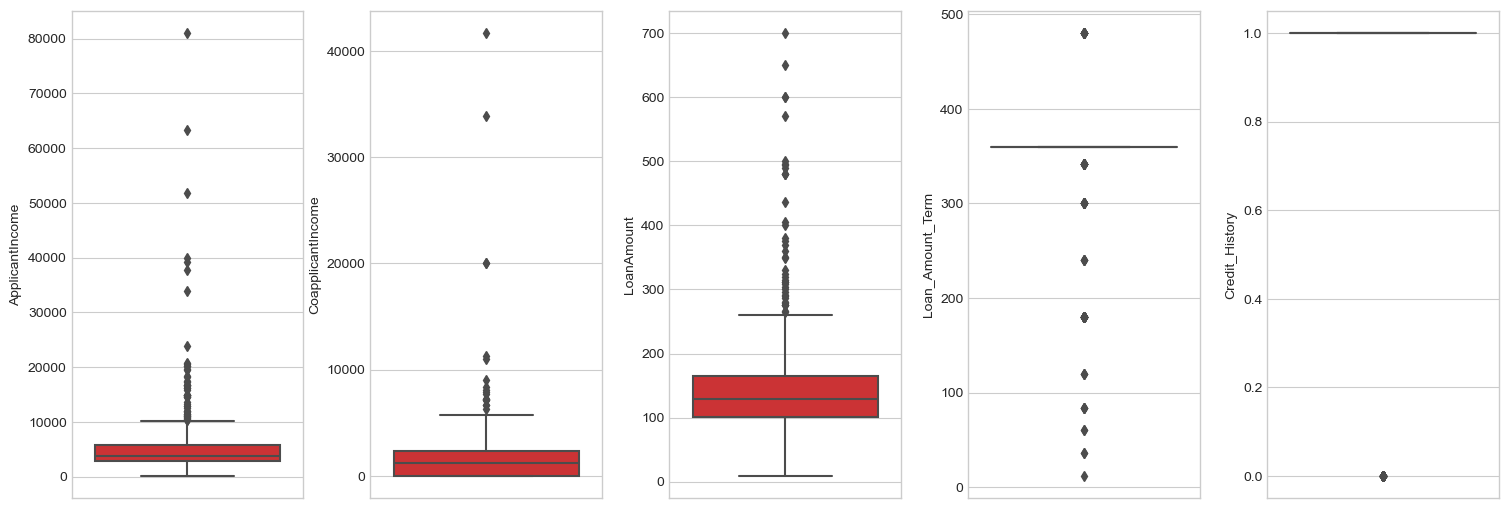

In [40]:
#Checking for outliers
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in data[number_dt].items():
    sns.boxplot(y=col, data=data, ax=ax[index], palette="Set1")
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

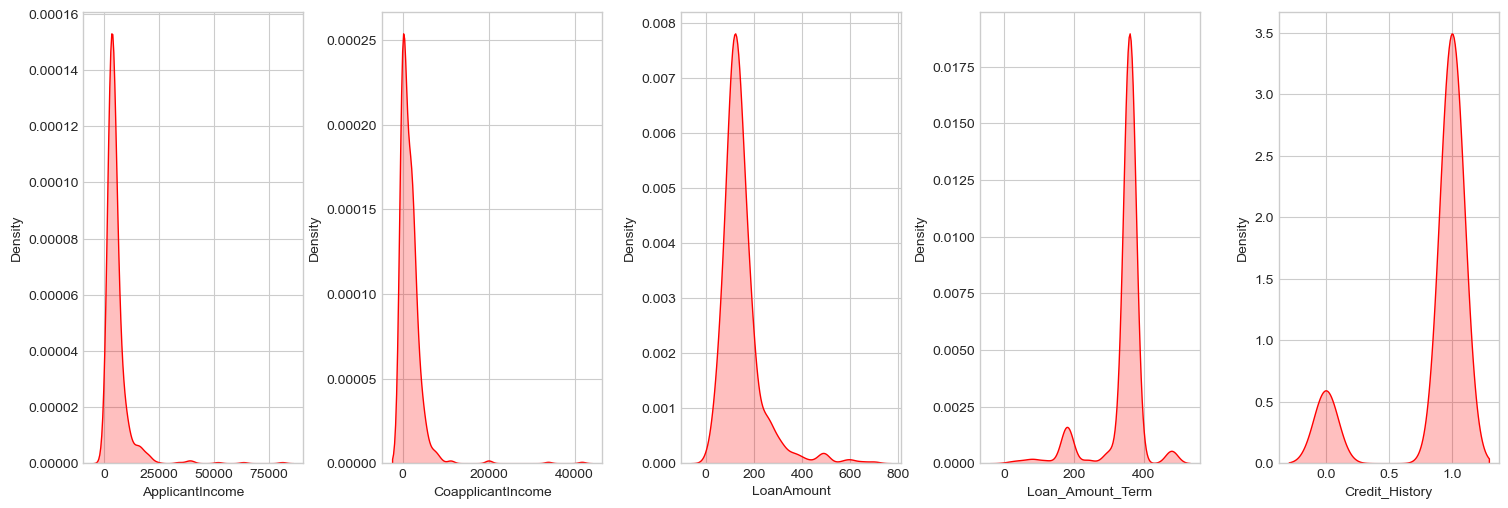

In [42]:
#Checking for skewness
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in data[number_dt].items():
    sns.distplot(value, ax=ax[index], hist=False, color="r", kde_kws={"shade": True})
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

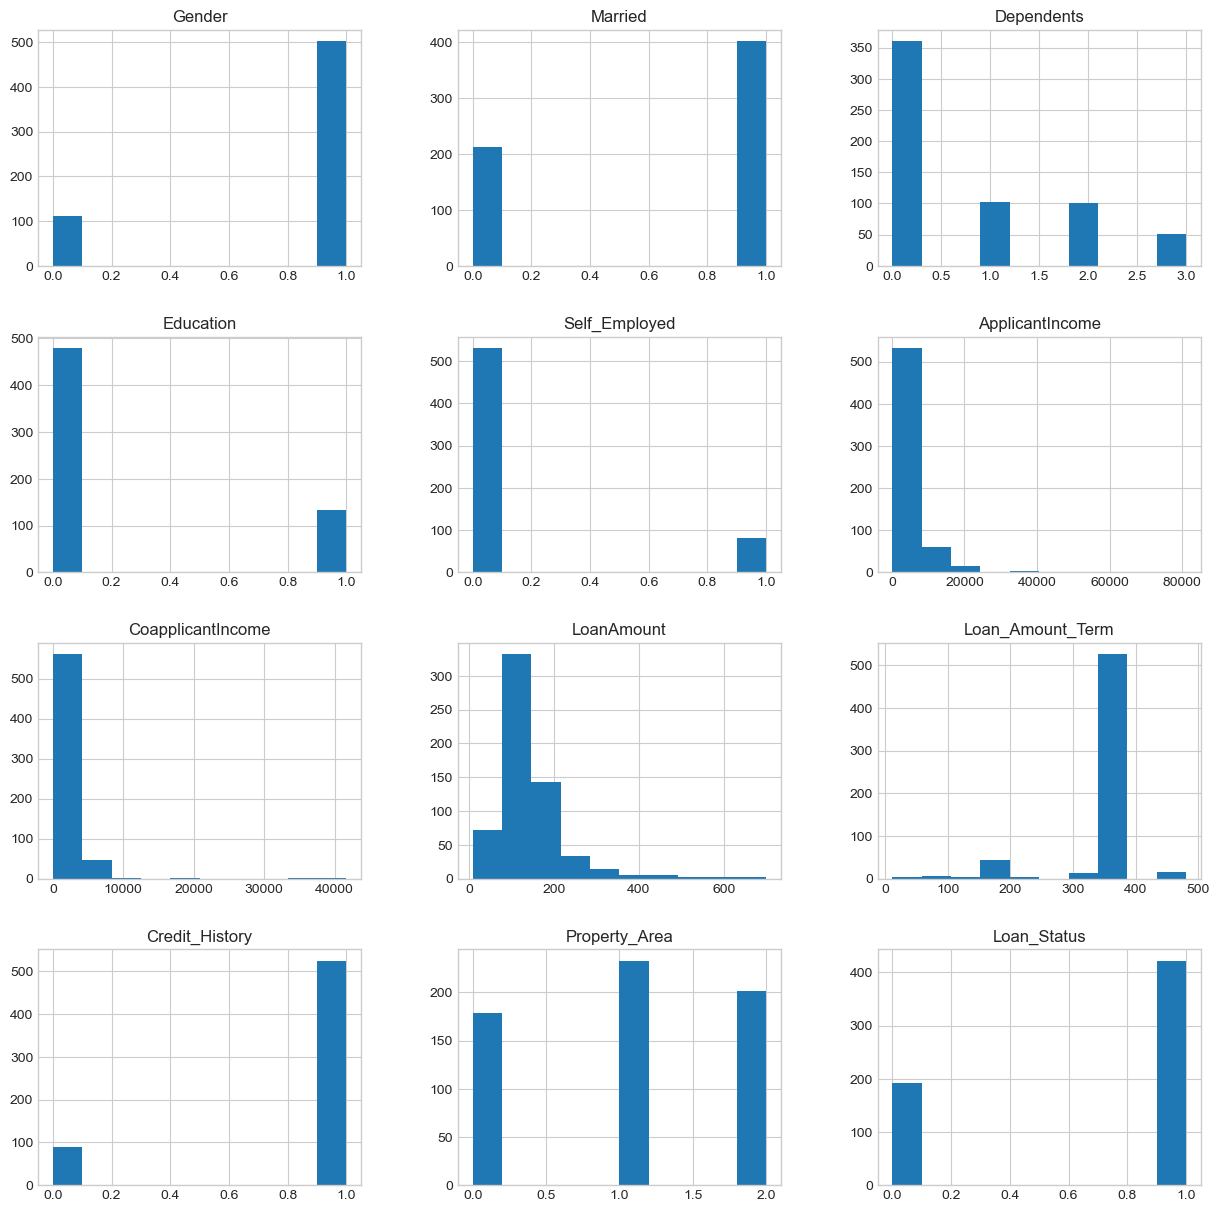

In [43]:
data.hist(figsize=(15,15))
plt.show()

Histogram for all our dataset columns after applying enconding and converting object datatype to numeric datatype values.


# Correlation 

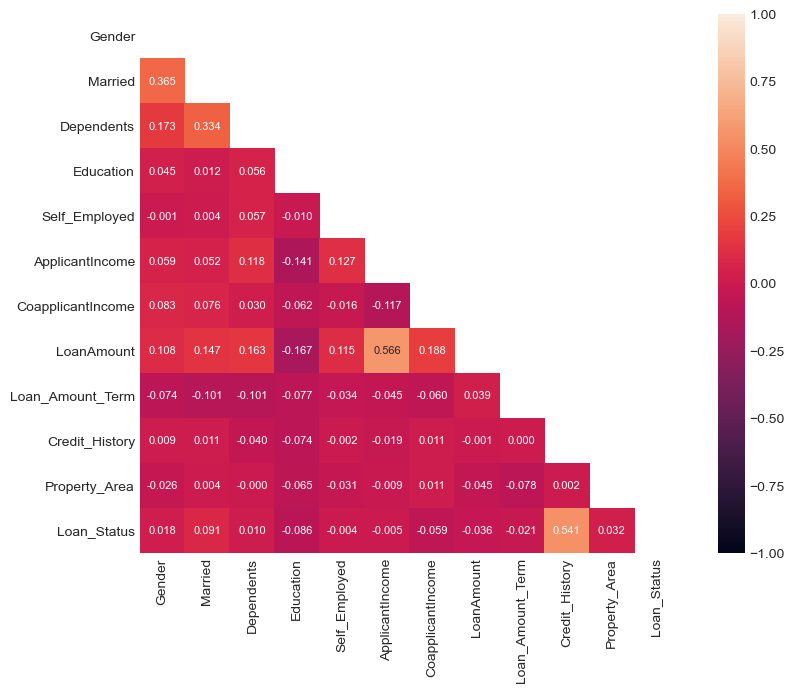

In [45]:
plt.style.use('seaborn-bright')
upper_triangle = np.triu(data.corr())
plt.figure(figsize=(10,7))
sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, square=True, fmt='0.3f', 
            annot_kws={'size':8}, mask=upper_triangle)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [46]:
#no multicolinearity

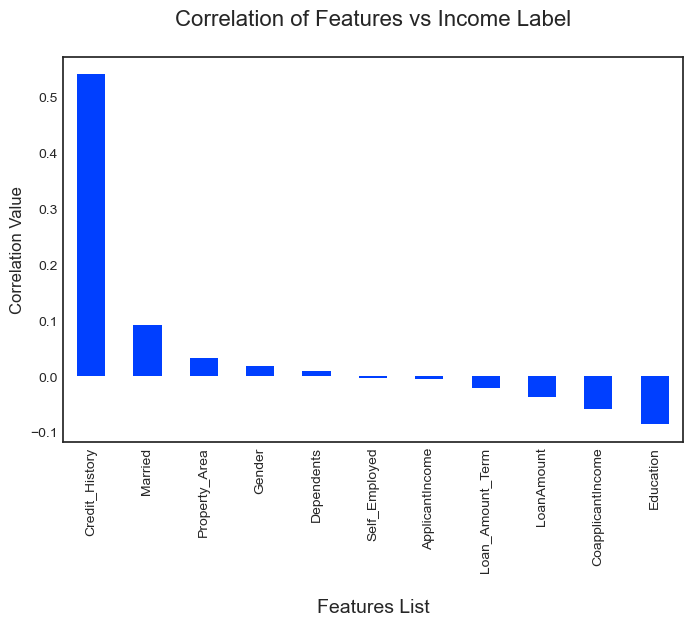

In [47]:
plt.style.use('seaborn-white')
data_corr = data.corr()
plt.figure(figsize=(8,5))
data_corr['Loan_Status'].sort_values(ascending=False).drop('Loan_Status').plot.bar()
plt.title("Correlation of Features vs Income Label\n", fontsize=16)
plt.xlabel("\nFeatures List", fontsize=14)
plt.ylabel("Correlation Value", fontsize=12)
plt.show()

Using Z Score to remove outliers

In [48]:
z = np.abs(zscore(data))
threshold = 3
data1 = data[(z<3).all(axis = 1)]

print ("Shape of before removing outliers: ", data.shape)
print ("Shape of after removing outliers: ", data1.shape)
print ("Percentage of data loss: ", (data.shape[0]-data1.shape[0])/data.shape[0]*100)

data=data1.copy() 

Shape of before removing outliers:  (614, 12)
Shape of after removing outliers:  (577, 12)
Percentage of data loss:  6.026058631921824


In [50]:
data.skew()

Gender              -1.622920
Married             -0.630211
Dependents           1.052106
Education            1.306588
Self_Employed        2.252848
ApplicantIncome      2.148522
CoapplicantIncome    1.350517
LoanAmount           1.113132
Loan_Amount_Term    -2.077031
Credit_History      -1.976043
Property_Area       -0.055332
Loan_Status         -0.822635
dtype: float64

Using Log Transform to fix skewness

In [52]:
for col in number_dt:
    if data.skew().loc[col]>0.55:
        data[col]=np.log1p(data[col])

# Spliting,Sampling and Scaling

In [53]:
X = data.drop('Loan_Status', axis=1)
Y = data['Loan_Status']

In [54]:
Y.value_counts()

1    398
0    179
Name: Loan_Status, dtype: int64

In [55]:
# adding samples to make all the categorical label values same

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

In [56]:
Y.value_counts()

0    398
1    398
Name: Loan_Status, dtype: int64

In [57]:
#Feature Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,0.487396,-1.339946,-0.706571,-0.584334,-0.383742,0.743380,-1.120993,0.393553,0.239574,0.579066,1.229174
1,0.487396,0.783158,0.320601,-0.584334,-0.383742,0.277137,0.795627,0.060884,0.239574,0.579066,-1.281156
2,0.487396,0.783158,-0.706571,-0.584334,2.781640,-0.532775,-1.120993,-1.572584,0.239574,0.579066,1.229174
3,0.487396,0.783158,-0.706571,1.788742,-0.383742,-0.818802,0.912624,-0.098747,0.239574,0.579066,1.229174
4,0.487396,-1.339946,-0.706571,-0.584334,-0.383742,0.792103,-1.120993,0.300286,0.239574,0.579066,1.229174


Best random state for building Classification Models

In [58]:
maxAccu=0
maxRS=0

for i in range(1, 1000):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=i)
    lr=LogisticRegression()
    lr.fit(X_train, Y_train)
    pred = lr.predict(X_test)
    acc_score = (accuracy_score(Y_test, pred))*100
    
    if acc_score>maxAccu:
        maxAccu=acc_score
        maxRS=i

print("Best accuracy score is", maxAccu,"on Random State", maxRS)

Best accuracy score is 82.41206030150754 on Random State 86


In [59]:
rf=RandomForestClassifier()
rf.fit(X_train, Y_train)
importances = pd.DataFrame({'Features':X.columns, 'Importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('Importance', ascending=False).set_index('Features')
importances.plot.bar
importances

,Importance
Features,
Credit_History,0.291
ApplicantIncome,0.176
LoanAmount,0.151
CoapplicantIncome,0.101
Property_Area,0.069
Dependents,0.051
Married,0.046
Education,0.037
Loan_Amount_Term,0.032


Machine Learning Model for Classification

In [60]:
# Classification Model Function

def classify(model, X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=86)
    
    # Training the model
    model.fit(X_train, Y_train)
    
    # Predicting Y_test
    pred = model.predict(X_test)
    
    # Classification Report
    class_report = classification_report(Y_test, pred)
    print("\nClassification Report:\n", class_report)
    
    # Accuracy Score
    acc_score = (accuracy_score(Y_test, pred))*100
    print("Accuracy Score:", acc_score)
    
    # Cross Validation Score
    cv_score = (cross_val_score(model, X, Y, cv=5).mean())*100
    print("Cross Validation Score:", cv_score)
    
    # Result of accuracy minus cv scores
    result = acc_score - cv_score
    print("\nAccuracy Score - Cross Validation Score is", result)

In [61]:
# Logistic Regression

model=LogisticRegression()
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.62      0.75        84
           1       0.78      0.97      0.86       115

    accuracy                           0.82       199
   macro avg       0.86      0.80      0.81       199
weighted avg       0.85      0.82      0.82       199

Accuracy Score: 82.41206030150754
Cross Validation Score: 73.875

Accuracy Score - Cross Validation Score is 8.537060301507537


In [62]:
# Support Vector Classifier

model=SVC(C=1.0, kernel='rbf', gamma='auto', random_state=42)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.64      0.75        84
           1       0.78      0.95      0.86       115

    accuracy                           0.82       199
   macro avg       0.84      0.80      0.80       199
weighted avg       0.83      0.82      0.81       199

Accuracy Score: 81.90954773869346
Cross Validation Score: 75.25550314465409

Accuracy Score - Cross Validation Score is 6.654044594039377


In [63]:
# Decision Tree Classifier

model=DecisionTreeClassifier(random_state=21, max_depth=15)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.77      0.72        84
           1       0.81      0.72      0.76       115

    accuracy                           0.74       199
   macro avg       0.74      0.75      0.74       199
weighted avg       0.75      0.74      0.75       199

Accuracy Score: 74.37185929648241
Cross Validation Score: 75.00550314465409

Accuracy Score - Cross Validation Score is -0.6336438481716726


In [64]:
# Random Forest Classifier

model=RandomForestClassifier(max_depth=15, random_state=111)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.83      0.86        84
           1       0.88      0.92      0.90       115

    accuracy                           0.88       199
   macro avg       0.88      0.88      0.88       199
weighted avg       0.88      0.88      0.88       199

Accuracy Score: 88.44221105527639
Cross Validation Score: 83.42845911949685

Accuracy Score - Cross Validation Score is 5.013751935779538


In [65]:
# Extra Trees Classifier

model=ExtraTreesClassifier()
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.83        84
           1       0.87      0.88      0.87       115

    accuracy                           0.85       199
   macro avg       0.85      0.85      0.85       199
weighted avg       0.85      0.85      0.85       199

Accuracy Score: 85.42713567839196
Cross Validation Score: 85.43396226415095

Accuracy Score - Cross Validation Score is -0.006826585758986425


In [66]:
# XGB Classifier

model=xgb.XGBClassifier(verbosity=0)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83        84
           1       0.87      0.89      0.88       115

    accuracy                           0.86       199
   macro avg       0.86      0.85      0.86       199
weighted avg       0.86      0.86      0.86       199

Accuracy Score: 85.92964824120602
Cross Validation Score: 79.0314465408805

Accuracy Score - Cross Validation Score is 6.898201700325529


In [67]:
# Choosing Extra Trees Classifier

fmod_param = {'criterion' : ['gini', 'entropy'],
              'n_jobs' : [-2, -1, 1],
              'random_state' : [42, 739, 1000],
              'max_depth' : [0, 15, 30],
              'n_estimators' : [100, 200, 300]
             }

In [68]:
#Selected Extra Trees Classifier as my best model

In [69]:
GSCV = GridSearchCV(ExtraTreesClassifier(), fmod_param, cv=5)

In [70]:
Final_Model = ExtraTreesClassifier(criterion='entropy', max_depth=30, n_estimators=100, n_jobs=-2, random_state=1000)
Classifier = Final_Model.fit(X_train, Y_train)
fmod_pred = Final_Model.predict(X_test)
fmod_acc = (accuracy_score(Y_test, fmod_pred))*100
print("Accuracy score for the Best Model is:", fmod_acc)

Accuracy score for the Best Model is: 84.92462311557789


In [71]:
#Hyperparameter tuning succesfully incorporated

AUC ROC Curve

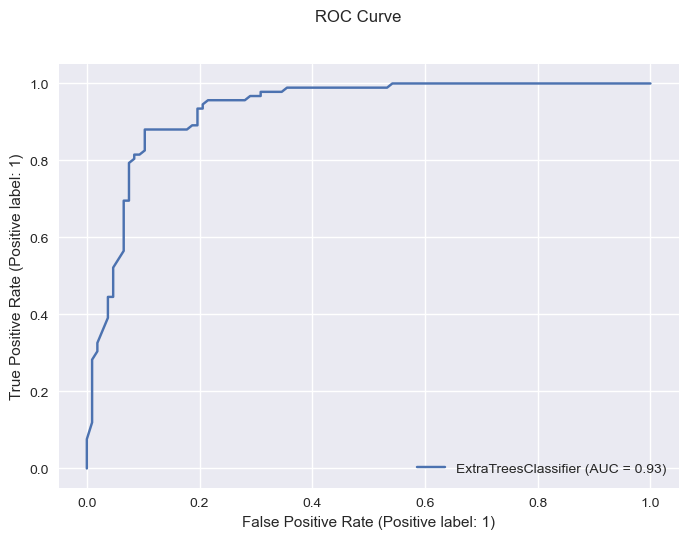

In [72]:
plt.style.use('seaborn')
disp = metrics.plot_roc_curve(Final_Model, X_test, Y_test)
disp.figure_.suptitle("ROC Curve")
plt.show()


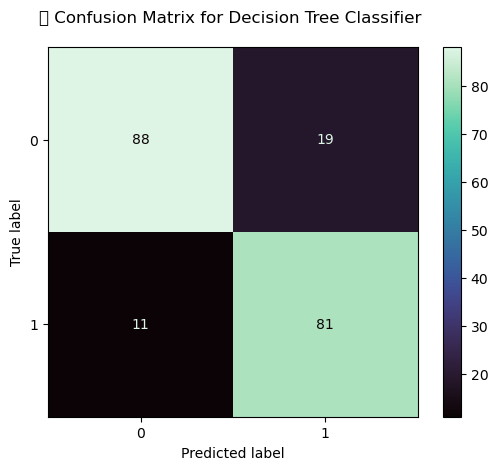

In [74]:
plt.style.use('default')
class_names = data.columns
metrics.plot_confusion_matrix(Classifier, X_test, Y_test, cmap='mako')
plt.title('\t Confusion Matrix for Decision Tree Classifier \n')
plt.show()

In [75]:
filename = "FinalModel_Loan.pkl"
joblib.dump(Final_Model, filename)
# saving the model

['FinalModel_Loan.pkl']